<center>
<img src="../../img/ods_stickers.jpg">
## Открытый курс по машинному обучению
</center>
<center>Автор материала: программист-исследователь Mail.ru Group, старший преподаватель <br>Факультета Компьютерных Наук ВШЭ Юрий Кашницкий

# <center> Домашнее задание № 8. Часть 1
## <center> Реализация алгоритмов онлайн-обучения

В первой части задания вам предлагается реализовать два алгоритма – регрессор и классификатор, обучаемые стохастическим градиентным спуском (Stochastic Gradient Descent, SGD). [Веб-форма](https://goo.gl/forms/z8zENbMiaEAeB7nG3) для ответов.

## План 1 части домашнего задания
    1.1. Линейная регрессия и SGD
    1.2. Логистическая регрессия и SGD
    1.3. Логистическая регрессия и SGDClassifier в задаче классификации отзывов к фильмам

В [статье](https://habrahabr.ru/company/ods/blog/326418/) было описано, как таким образом обучать регрессор, т.е. минимизировать квадратичную функцию потерь. Реализуем этот алгоритм.

Вначале проверим версии библиотек с помощью расширения [watermark](https://github.com/rasbt/watermark). Заодно и Vowpal Wabbit, который понадобится во 2 части задания – версия должна быть последняя на момент написания, 8.3.2.

In [8]:
#pip install watermark
%load_ext watermark

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark


In [9]:
%watermark -v -m -p numpy,scipy,pandas,matplotlib,sklearn

CPython 3.6.0
IPython 5.1.0

numpy 1.12.0
scipy 0.18.1
pandas 0.19.2
matplotlib 1.5.3
sklearn 0.18.1

compiler   : GCC 4.2.1 Compatible Apple LLVM 8.0.0 (clang-800.0.42.1)
system     : Darwin
release    : 16.5.0
machine    : x86_64
processor  : i386
CPU cores  : 4
interpreter: 64bit


In [10]:
!vw --version

8.3.1


##  1.1. Линейная регрессия и SGD

In [2]:
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.base import BaseEstimator
from sklearn.metrics import mean_squared_error, log_loss, roc_auc_score
from sklearn.model_selection import train_test_split
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

Реализуйте класс `SGDRegressor`. Спецификация:
- класс наследуется от `sklearn.base.BaseEstimator`
- конструктор принимает параметры `eta` – шаг градиентного спуска (по умолчанию $10^{-3}$) и `n_iter` – число проходов по выборке (по умолчанию 10)
- также в конструкторе должны создаваться списки `mse_` и `weights_` для отслеживания значений среднеквадратичной ошибки и вектора весов по итерациям градиентного спуска
- Класс имеет методы `fit` и `predict`
- Метод `fit` принимает матрицу `X` и вектор `y` (объекты `numpy.array`), добавляет к матрице `X` слева столбец из единиц, инициализирует вектор весов `w` **нулями** и в цикле с числом итераций `n_iter` обновляет веса (см. [статью](https://habrahabr.ru/company/ods/blog/326418/)), а также записывает получившиеся на данной итерации значения среднеквадратичной ошибки (именно MSE, SE слишком большими будут) и вектор весов `w` в предназначенные для этого списки. 
- В конце метод `fit` создает переменную `w_`, в которой хранится тот вектор весов, при котором ошибка минимальна
- Метод `fit` должен возвращать текущий экземпляр класса `SGDRegressor`, т.е. `self`
- Метод `predict` принимает матрицу `X`, добавляет к ней слева столбец из единиц и возвращает вектор прогнозов модели, используя созданный методом `fit` вектор весов `w_`.

In [80]:
class SGDRegressor(BaseEstimator):
    def __init__(self, eta=0.001, n_iter=10):
        self.eta = eta
        self.n_iter = n_iter
        self.mse_ = []
        self.weights_ = []
    
    def fit(self, X, y):
        X_prepended = np.insert(X, 0, 1, axis=1)
        self.weights_.append(np.zeros(shape=X_prepended.shape[1]))
        self.mse_.append(mean_squared_error(y, np.dot(self.weights_[-1], X_prepended.transpose()).flatten()))
        self.min_mse = self.mse_[-1]
        self.w_ = self.weights_[-1]
        for _ in range(self.n_iter):
            for X_i, y_i in zip(X_prepended, y):
                next_weights = self.weights_[-1] - self.eta * (np.dot(X_i, self.weights_[-1]) - y_i) * X_i
                next_mse = mean_squared_error(y, np.dot(next_weights, X_prepended.transpose()).flatten())
                if (next_mse <= self.min_mse):
                    self.w_ = next_weights
                    self.min_mse = next_mse
                self.weights_.append(next_weights)
                self.mse_.append(next_mse)
        return self

    def predict(self, X):
        X_prepended = np.insert(X, 0, 1, axis=1)
        return np.dot(self.w_, X_prepended.transpose()).flatten()

In [56]:
ar = np.array([
    np.array([1,2,3]),
    np.array([4,5,6]),
    np.array([7,8,9]),
])
ar = np.insert(ar, 0, 1, axis=1)
print(ar)
w = np.ones(shape=ar.shape[1])
print(w)
y = np.zeros(shape=ar.shape[0])
print(y)
ws = [w]
mse = [mean_squared_error(np.ones(shape=ar.shape[0]), np.dot(w, ar.transpose()).flatten())]
for ar_i, y_i in zip(ar, y):
    ws.append(ws[-1] - 0.001 * (np.dot(ar_i, ws[-1]) - y_i) * ar_i)
    mse.append(mean_squared_error(np.ones(shape=ar.shape[0]), np.dot(ws[-1], ar.transpose()).flatten()))
print(mse)
print(ws)

[[1 1 2 3]
 [1 4 5 6]
 [1 7 8 9]]
[ 1.  1.  1.  1.]
[ 0.  0.  0.]
[279.0, 270.62194500000004, 227.74323888167396, 143.91230721790194]
[array([ 1.,  1.,  1.,  1.]), array([ 0.993,  0.993,  0.986,  0.979]), array([ 0.977231,  0.929924,  0.907155,  0.884386]), array([ 0.95452759,  0.77100011,  0.7255277 ,  0.68005528])]


In [11]:
a = np.array([[1,0,1]])
b = np.array([[0.8, 0.7, 0.6]])
log_loss(a.T, b.T)

0.64598065980204544

Проверим работу алгоритма на данных по росту и весу. Будем прогнозировать рост (в дюймах) по весу (в фунтах).

In [79]:
data_demo = pd.read_csv('../../data/weights_heights.csv')

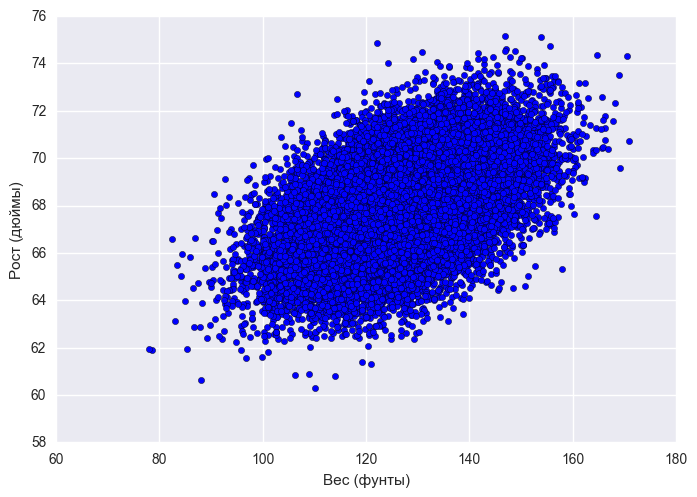

In [81]:
plt.scatter(data_demo['Weight'], data_demo['Height']);
plt.xlabel('Вес (фунты)')
plt.ylabel('Рост (дюймы)');

In [82]:
X, y = data_demo['Weight'].values, data_demo['Height'].values

Выделим 70% под обучение, 30% – под проверку и масштабируем выборку.

In [83]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y,
                                                     test_size=0.3,
                                                     random_state=17)

In [84]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.reshape([X_train.shape[0], 1]))
X_valid_scaled = scaler.transform(X_valid.reshape([X_valid.shape[0], 1]))

Обучите созданный вами `SGDRegressor` на выборке `(X_train_scaled, y_train)`. Параметры оставьте по умолчанию.

In [85]:
sr = SGDRegressor()
sr.fit_intercept(X_train_scaled, y_train)
y_valid_predicted = sr.predict(X_valid_scaled)

AttributeError: 'SGDRegressor' object has no attribute 'fit_intercept'

Изобразите на графике процесс обучения – как среднеквадратичная ошибка зависит от номера итерации стохастического градиентного спуска.

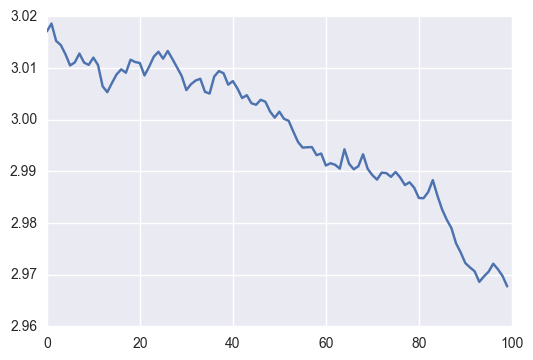

In [138]:
plt.plot(sr.mse_[4800:4900])
plt.show()

Выведите наименьшее значение среднеквадратичной ошибки и лучший вектор весов модели.

In [139]:
print(sr.min_mse)
print(sr.w_)

2.71513524066
[ 67.9898497    0.94447605]


Постройте график того, как менялись значения весов модели ($w_0$ и $w_1$) по мере обучения.

In [ ]:
''' ВАШ КОД ЗДЕСЬ '''

Сделайте прогноз для отложенной выборки `(X_valid_scaled, y_valid)` и посмотрите на MSE.

In [140]:
sr_mse = mean_squared_error(y_valid, y_valid_predicted)
sr_mse

2.6708681207033784

Теперь следайте то же самое, но с `LinearRegression` из `sklearn.linear_model`. Посчитайте MSE для отложенной выборки.

In [141]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
y_valid_predicted = lr.predict(X_valid_scaled)
lr_mse = mean_squared_error(y_valid, y_valid_predicted)
lr_mse

2.6708307676676348

<font color='red'>Вопрос 1.</font> В каком знаке после разделителя отличаются MSE линейной регрессии и `SGDRegressor` для отложенной выборки?
 - 2
 - 3
 - 4
 - **5**

## 1.2. Логистическая регрессия и SGD
Теперь давайте разберемся, как при таком же стохастическом подходе обучать логистическую регрессию.

Задача классификации, $X$ – обучающая выборка размеров $\ell \times (d+1)$ (первый столбец – вектор из единиц), $y$ – вектор ответов, $y_i \in \{-1, 1\}$.
В [4 статье](https://habrahabr.ru/company/ods/blog/323890/) серии мы подробно разбирали, как логистическая регрессия с $L_2$-регуляризацией сводится к задаче минимизации:
$$ C\sum_{i=1}^\ell \log{(1 + e^{-y_iw^Tx_i})} + \frac{1}{2}\sum_{j=1}^d w_j^2 \rightarrow min_w$$

<font color='red'>Вопрос 2.</font> По какой формуле будут пересчитываться веса логистической регрессии при обучении стохастическим градиентным спуском?
 - $w_j^{(t+1)} = w_j^{(t)} + \eta (Cy_i x_{ij} \sigma(y_iw^Tx_i) +  \delta_{j\neq0} w_j)$
 - $w_j^{(t+1)} = w_j^{(t)} - \eta (Cy_i x_{ij} \sigma(-y_iw^Tx_i) +  \delta_{j\neq0}w_j)$
 - $w_j^{(t+1)} = w_j^{(t)} - \eta (Cy_i x_{ij} \sigma(y_iw^Tx_i) -  \delta_{j\neq0}w_j )$
 - $w_j^{(t+1)} = w_j^{(t)} + \eta (Cy_i x_{ij} \sigma(-y_iw^Tx_i) -  \delta_{j\neq0}w_j)$ (Это ответ)
 
Здесь 
- $i \in {0,\ldots, \ell-1}, j \in {0,\ldots, d}$
- C – коэффициент регуляризации
- $x_{ij} $ – элемент матрицы X в строке $i$ и столбце $j$ (нумерация с 0), 
- $x_i$ – $i$-ая строка матрицы $X$ (нумерация с 0), 
- $w_j^{(t)}$ – значение $j$-ого элемента вектора весов $w$ на шаге $t$ стохастического градиентного спуска
- $\eta$ – небольшая константа, шаг градиентного спуска
- $\delta_{j\neq0}$ – символ Кронекера, то есть 1, когда $j\neq0$ и $0$ – в противном случае

Реализуйте класс `SGDClassifier`. Спецификация:
- класс наследуется от `sklearn.base.BaseEstimator`
- конструктор принимает параметры `eta` – шаг градиентного спуска (по умолчанию $10^{-3}$), `n_iter` – число проходов по выборке (по умолчанию 10) и C – коэффициент регуляризации
- также в конструкторе должны создаваться списки `loss_` и `weights_` для отслеживания значений логистических потерь и вектора весов по итерациям градиентного спуска
- Класс имеет методы `fit`, `predict` и `predict_proba`
- Метод `fit` принимает матрицу `X` и вектор `y` (объекты `numpy.array`, рассматриваем только случай бинарной классификации, и значения в векторе `y` могут быть -1 и 1), добавляет к матрице `X` слева столбец из единиц, инициализирует вектор весов `w` **нулями** и в цикле с числом итераций `n_iter` обновляет веса по выведенной вами формуле, а также записывает получившиеся на данной итерации значения log_loss и вектор весов `w` в предназначенные для этого списки. 
- В конце метод `fit` создает переменную `w_`, в которой хранится тот вектор весов, при котором ошибка минимальна
- Метод `fit` должен возвращать текущий экземпляр класса `SGDClassifier`, т.е. `self`
- Метод `predict_proba` принимает матрицу `X`, добавляет к ней слева столбец из единиц и возвращает матрицу прогнозов модели (такую же, какую возвращают методы `predict_proba` моделей `sklearn`), используя созданный методом `fit` вектор весов `w_`
- Метод `predict` вызывает метод  `predict_proba` и возвращает вектор ответов: -1, если предсказанная вероятность класса 1 меньше 0.5 и 1 – в противном случае
- И еще **важный момент**: во избежание вычислительных проблем из-за слишком больших или малых значений под экспонентной (overflow & underflow) используйте написанную функцию `sigma`

In [63]:
def sigma(z):
    z = z.flatten()
    z[z > 100] = 100
    z[z < -100] = -100
    return 1. / (1 + np.exp(-z))

In [64]:
class SGDClassifier(BaseEstimator):
    def __init__(self, C, eta=0.001, n_iter=10):
        self.C = C
        self.eta = eta
        self.n_iter = n_iter
        self.loss_ = []
        self.weights_ = []

    def fit(self, X, y):
        X_prepended = np.insert(X, 0, 1, axis=1)
        self.weights_.append(np.zeros(shape=X_prepended.shape[1]))
        self.loss_.append(log_loss(y, sigma(np.dot(self.weights_[-1], X_prepended.transpose()))))
        self.min_loss = self.loss_[-1]
        self.w_ = self.weights_[-1]
        for _ in range(self.n_iter):
            for X_i, y_i in zip(X_prepended, y):
                next_weights = self.weights_[-1] + self.eta * (
                    self.C * y_i * X_i * sigma(-1 * y_i * np.dot(self.weights_[-1], X_i)) -
                        np.insert(self.weights_[-1][1:], 0, 0)
                )
                next_loss = log_loss(y, sigma(np.dot(next_weights, X_prepended.transpose())))
                if (next_loss <= self.min_loss):
                    self.w_ = next_weights
                    self.min_loss = next_loss
                self.weights_.append(next_weights)
                self.loss_.append(next_loss)
        return self
    
    def predict_proba(self, X):
        X_prepended = np.insert(X, 0, 1, axis=1)
        return np.array([sigma(-1 * np.dot(self.w_, X_prepended.transpose())),
                         sigma(np.dot(self.w_, X_prepended.transpose()))]).transpose()
    
    def predict(self, X):
        probs = self.predict_proba(X)
        return np.array([-1 if prob < 0.5 else 1 for prob in probs[:, 1]])

Проверим `SGDClassifier` на данных UCI по раку молочной железы.

In [252]:
from sklearn.datasets import load_breast_cancer

In [253]:
cancer = load_breast_cancer()
cancer.feature_names

array(['mean radius', 'mean texture', 'mean perimeter', 'mean area',
       'mean smoothness', 'mean compactness', 'mean concavity',
       'mean concave points', 'mean symmetry', 'mean fractal dimension',
       'radius error', 'texture error', 'perimeter error', 'area error',
       'smoothness error', 'compactness error', 'concavity error',
       'concave points error', 'symmetry error', 'fractal dimension error',
       'worst radius', 'worst texture', 'worst perimeter', 'worst area',
       'worst smoothness', 'worst compactness', 'worst concavity',
       'worst concave points', 'worst symmetry', 'worst fractal dimension'], 
      dtype='<U23')

In [254]:
# поменяем метки в y с 0 на -1
X, y = cancer.data, [-1 if i == 0 else 1 for i in cancer.target]

Выделим 70% под обучение, 30% – под проверку и масштабируем выборку.

In [255]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y,
                                                     test_size=0.3,
                                                     random_state=17)

In [256]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)

Обучите на масштибированной выборке `SGDClassifier` с параметрами `C`=1, `eta`=$10^{-3}$ и `n_iter`=3.

In [269]:
sc = SGDClassifier(C=1, n_iter=3)
sc.fit(X_train_scaled, y_train)
res = sc.predict_proba(X_valid_scaled[:10])
res

array([[ 0.31751743,  0.68248257],
       [ 0.22872307,  0.77127693],
       [ 0.19766598,  0.80233402],
       [ 0.22840617,  0.77159383],
       [ 0.13182076,  0.86817924],
       [ 0.24313945,  0.75686055],
       [ 0.19395824,  0.80604176],
       [ 0.90785578,  0.09214422],
       [ 0.40123092,  0.59876908],
       [ 0.73688576,  0.26311424]])

In [267]:
sc.predict(X_valid_scaled[:10])

array([ 1,  1,  1,  1,  1,  1,  1, -1,  1, -1])

Постройте график изменения log_loss.

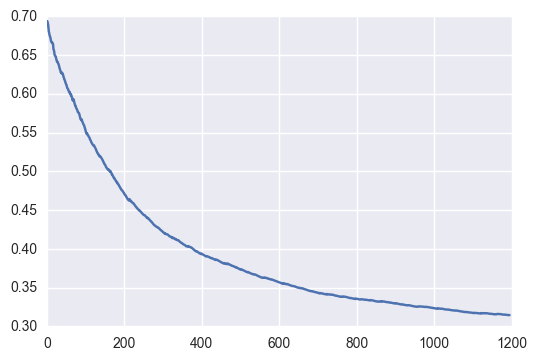

In [258]:
plt.plot(sc.loss_)
plt.show()

Теперь обучите `SGDClassifier` с параметром `C`=1000, число проходов по выборке увеличьте до 10.

In [271]:
sc = SGDClassifier(C=1000)
sc.fit(X_train_scaled, y_train)
sc.min_loss

0.04878601036435283

Посмотрите на веса модели, при которых ошибка на обучении была минимальна.

<font color='red'>Вопрос 3.</font> Какой признак сильнее остальных влияет на вероятность того, что опухоль доброкачественна, согласно обученной модели `SGDClassifier`? (будьте внимательны – проверьте длину вектора весов, полученного после обучения, сравните с числом признаков в исходной задаче)
 - worst compactness
 - worst smoothness
 - **worst concavity**
 - concave points error
 - concavity error
 - compactness error
 - worst fractal dimension

In [261]:
sorted(list(zip(cancer.feature_names, sc.w_[1:])), key=lambda tup: abs(tup[1]), reverse=True)

[('worst concavity', -5.1073427725992753),
 ('fractal dimension error', 4.6606676990251428),
 ('compactness error', 4.5350588374655025),
 ('radius error', -4.5318187974227806),
 ('worst texture', -4.0515637077932389),
 ('mean concavity', -3.5669096433764618),
 ('mean concave points', -3.5432757346361599),
 ('mean texture', -3.413873553481086),
 ('area error', -3.1545840145111503),
 ('worst radius', -2.9241860576068484),
 ('mean fractal dimension', 2.8603495441985567),
 ('texture error', 2.7917743029417816),
 ('perimeter error', -2.5752886070630847),
 ('worst area', -2.5113852307154114),
 ('worst fractal dimension', -2.2929781671116327),
 ('worst concave points', -1.9790998151068242),
 ('mean compactness', 1.9782699090761113),
 ('worst smoothness', -1.8587154014723588),
 ('mean area', -1.6649313452894017),
 ('mean radius', -1.6575531973741624),
 ('worst perimeter', -1.6395521948228615),
 ('worst symmetry', -1.5991014712953793),
 ('mean perimeter', -1.4098222612879519),
 ('worst compactn

Посчитайте log_loss и ROC AUC на отложенной выборке, проделайте все то же с `sklearn.linear_model.LogisticRegression` (параметры по умолчанию, только random_state=17) и сравните результаты.

In [270]:
sc_probs = sc.predict_proba(X_valid_scaled)[:, 1]
sc_log_loss = log_loss(y_valid, sc_probs)
sc_roc_auc = roc_auc_score(y_valid, sc_probs)
print('SGDClassifier:')
print('\tLog loss: %.9f' % sc_log_loss)
print('\tROC AUC: %.9f' % sc_roc_auc)

SGDClassifier:
	Log loss: 0.313573436
	ROC AUC: 0.980178838


In [263]:
from sklearn.linear_model import LogisticRegression

logr = LogisticRegression(random_state=17)
logr.fit(X_train_scaled, y_train)
logr_probs = logr.predict_proba(X_valid_scaled)[:, 1]
logr_log_loss = log_loss(y_valid, logr_probs)
logr_roc_auc = roc_auc_score(y_valid, logr_probs)
print('LogisticRegression:')
print('\tLog loss: %.9f' % logr_log_loss)
print('\tROC AUC: %.9f' % logr_roc_auc)

LogisticRegression:
	Log loss: 0.105692135
	ROC AUC: 0.989269747


(23.1531130400211, 41.40617905177463, -46.267005436767626)


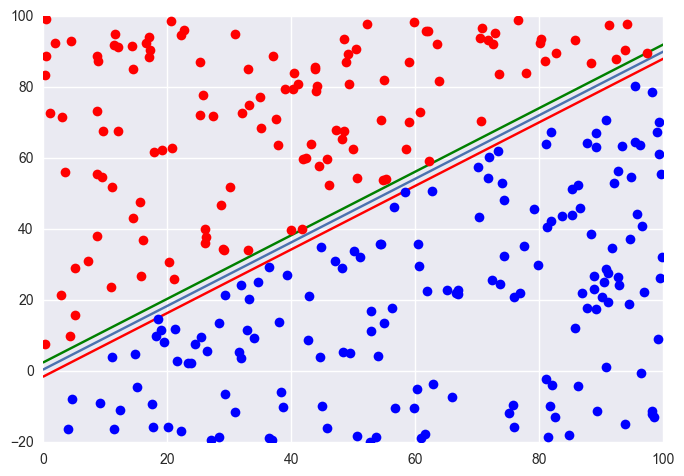

In [76]:
random.seed(84)
w0 = (random.random() - 0.5) * 100
w1 = (random.random() - 0.5) * 100
w2 = (random.random() - 0.5) * 100
t1 = np.linspace(0, 100, 1000)
t2 = (- w0 - w1 * t1) / w2
t2_bot = t2 - 2
t2_top = t2 + 2
print((w0, w1, w2))
plt.plot(t1, t2)
plt.plot(t1, t2_bot, 'r')
plt.plot(t1, t2_top, 'g')
X = []
y = []
for _ in range(300):
    x_1 = random.random() * 100
    x_2 = random.random() * 120 - 20
    if (- w0 - w1 * x_1) / w2 < (x_2 - 2):
        X.append(np.array([x_1, x_2]))
        y.append(-1)
    if (- w0 - w1 * x_1) / w2 > (x_2 + 2):
        X.append(np.array([x_1, x_2]))
        y.append(1)
X = np.array(X)
y = np.array(y)
plt.plot(X[y == 1][:, 0], X[y == 1][:, 1], 'bo')
plt.plot(X[y == -1][:, 0], X[y == -1][:, 1], 'ro')
plt.show()

In [77]:
sc = SGDClassifier(C=10)
sc.fit(X, y)
sc.w_

array([ 0.03533519,  1.75311881, -1.95198422])

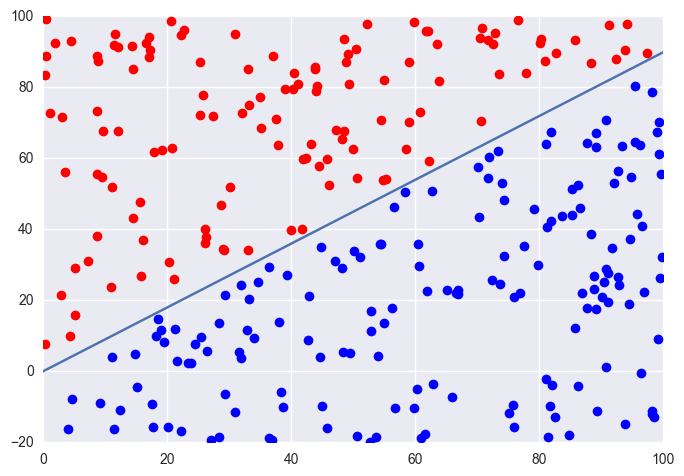

In [78]:
l1 = np.linspace(0, 100, 1000)
l2 = (- sc.w_[0] - sc.w_[1] * l1) / sc.w_[2]
plt.plot(l1, l2)
plt.plot(X[y == 1][:, 0], X[y == 1][:, 1], 'bo')
plt.plot(X[y == -1][:, 0], X[y == -1][:, 1], 'ro')
plt.show()

## 1.3. Логистическая регрессия и SGDClassifier в задаче классификации отзывов к фильмам

Теперь посмотрим на логистическую регрессию и ее же версию, но обучаемую стохастическим градиентным спуском, в задаче классификации отзывов IMDB. С этой задачей мы знакомы по 4 и 8 темам курса. Данные можно скачать [отсюда](https://yadi.sk/d/Tg1Tflur333iLr).

Импортируем файлы, и обучим на имеющихся данных `CountVectorizer`

In [87]:
from sklearn.datasets import load_files
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import SGDClassifier

In [88]:
# поменяйте путь к файлу
reviews_train = load_files("/Users/henadz.varantsou/datasets/aclImdb/train")
text_train, y_train = reviews_train.data, reviews_train.target

KeyboardInterrupt: 

In [235]:
reviews_test = load_files("/Users/henadz.varantsou/datasets/aclImdb/test")
text_test, y_test = reviews_test.data, reviews_test.target

Обучим на имеющихся данных `CountVectorizer`, считая биграммы, то есть перейдем к разреженному представлению данных, где каждому уникальному слову и паре подряд идущих слов в обучающей выборке соответсвует признак. Всего таких признаков получается более 1.5 млн.

In [236]:
%%time
cv = CountVectorizer(ngram_range=(1, 2))
X_train = cv.fit_transform(text_train)
X_test = cv.transform(text_test)

CPU times: user 48.5 s, sys: 1.1 s, total: 49.6 s
Wall time: 50.2 s


In [237]:
X_train.shape, X_test.shape

((25000, 1513832), (25000, 1513832))

Обучите на выборке `(X_train, y_train)` логистическую регрессию с параметрами по умолчанию (только укажите `random_state`=17) и посчитайте ROC AUC на тестовой выборке. Замерьте время обучения модели. Данные можно не масштабировать, так как признаки – по сути, счетчики, и они уже все измеряются примерно в одном диапазоне.

In [86]:
%%time
logr = LogisticRegression(random_state=17)
logr.fit(X_train, y_train)

NameError: name 'LogisticRegression' is not defined

In [249]:
roc_auc_score(y_test, logr.predict_proba(X_test)[:,1])

0.95825278080000009

Теперь перейдем к онлайн-алгоритму. Мы написали свой `SGDClassifier` и принцип его работы поняли, надо еще немного постараться, чтобы сделать его эффективным, например, сделать поддержку разреженных данных. Но мы теперь перейдем к `sklearn`-реализации SGD-алгоритма. Прочитайте документацию [SGDClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html), сделайте выводы, чем `SGDClassifier` из `Sklearn` более продвинут, чем наша реализация SGD-классификатора. 

<font color='red'>Вопрос 4.</font> Чем `sklearn`-реализация стохастического классификатора более продвинута, чем `SGDClassifier`, который мы реализовали? Отметьте все подходящие варианты.
 - **Изменяемый шаг градиентного спуска**
 - **Реализован линейный SVM**
 - Реализована ранняя остановка во избежание переобучения
 - **Есть распараллеливание по процессорам**
 - **Можно обучать LASSO**
 - Поддерживается онлайн-обучение деревьев решений
 - **Поддерживается mini-batch подход (обновление весов по нескольким объектом сразу, а не по одному)**


Проведите 100 итераций SGD-логрегрессии (опять `random_state`=17) на той же выборке. Опять замерьте время обучения модели и обратите внимание, насколько оно меньше, чем время обучения логистической регрессии.

In [247]:
%%time
sc = SGDClassifier(loss='log', n_iter=100, random_state=17)
sc.fit(X_train, y_train)

CPU times: user 11.3 s, sys: 128 ms, total: 11.5 s
Wall time: 12 s


In [248]:
roc_auc_score(y_test, sc.predict_proba(X_test)[:,1])

0.95734586880000005

<font color='red'>Вопрос 5.</font> В каком знаке после разделителя отличаются ROC AUC на тестовой выборке логистической регрессии и SGD-классификатора `Sklearn` с логистической функцией потерь?
 - 2
 - **3**
 - 4
 - 5